# Criminal Recidivism Prediction
#### CHAPTER 06: _Anchor and Counterfactual Explanations_
##### From **Interpretable Machine Learning with Python 2nd Edition** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

In [ ]:
!pip install pandas==1.3.5
!pip install numpy==1.21.6
!pip install scikit-learn==1.0.2
!pip install matplotlib==3.5.1
!pip install seaborn==0.11.0
!pip install alibi==0.6.5

!pip install tensorflow==2.2.0
!pip install catboost==0.24.1
!pip install shap==0.37.0
!pip install witwidget==1.7.0

In [ ]:
!pip install pathlib2==2.3.5
!pip install scipy==1.4.1
!pip install statsmodels==0.11.0
!pip install mlxtend==0.19.0
!pip install pycebox==0.0.1
!pip install aif360==0.3.0
!pip install opencv-python==4.4.0.44
!pip install tqdm==4.62.3

### Loading the Libraries

In [1]:
import math
import mldatasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
from alibi.explainers import AnchorTabular, CounterFactualProto
import shap
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [2]:
print(tf.__version__) 

2.2.0


In [3]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly())

Eager execution enabled:  False


### Understanding and Preparing the Data

In [4]:
recidivism_df = mldatasets.load("recidivism-risk", prepare=True)

https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter6/data/cox-violent-parsed_filt.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter6/data folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/Chapter6/data/cox-violent-parsed_filt.csv


In [5]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14788 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    14788 non-null  int8 
 1   juv_fel_count          14788 non-null  int8 
 2   juv_misd_count         14788 non-null  int8 
 3   juv_other_count        14788 non-null  int64
 4   priors_count           14788 non-null  int8 
 5   is_recid               14788 non-null  int8 
 6   sex_Female             14788 non-null  uint8
 7   sex_Male               14788 non-null  uint8
 8   race_African-American  14788 non-null  uint8
 9   race_Asian             14788 non-null  uint8
 10  race_Caucasian         14788 non-null  uint8
 11  race_Hispanic          14788 non-null  uint8
 12  race_Native American   14788 non-null  uint8
 13  race_Other             14788 non-null  uint8
 14  c_charge_degree_(F1)   14788 non-null  uint8
 15  c_charge_degree_(F2)   14788 non-nul

#### Examining Predictive Bias with Confusion Matrices

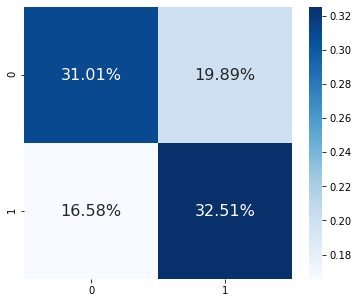

In [6]:
cf_matrix = metrics.confusion_matrix(recidivism_df.is_recid,\
                                     recidivism_df.compas_score)
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16})
plt.show()

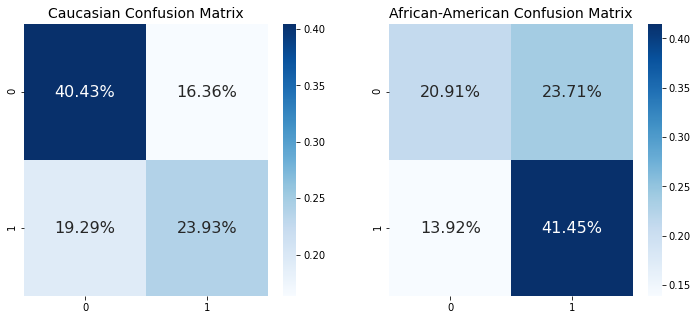

	African-American FPR:	53.1%
	Caucasian FPR:		28.8%
	Ratio FPRs:		1.84 x


In [7]:
recidivism_c_df = recidivism_df[recidivism_df['race_Caucasian'] == 1]
recidivism_aa_df = recidivism_df[recidivism_df['race_African-American'] == 1]

_ = mldatasets.\
      compare_confusion_matrices(recidivism_c_df.is_recid, 
                                 recidivism_c_df.compas_score,\
                                 recidivism_aa_df.is_recid,\
                                 recidivism_aa_df.compas_score,\
                                 'Caucasian', 'African-American', compare_fpr=True) 

#### Data Preparation

In [8]:
rand = 9
np.random.seed(rand)

y = recidivism_df['compas_score']
X = recidivism_df.drop(['compas_score', 'is_recid'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

#### Modeling

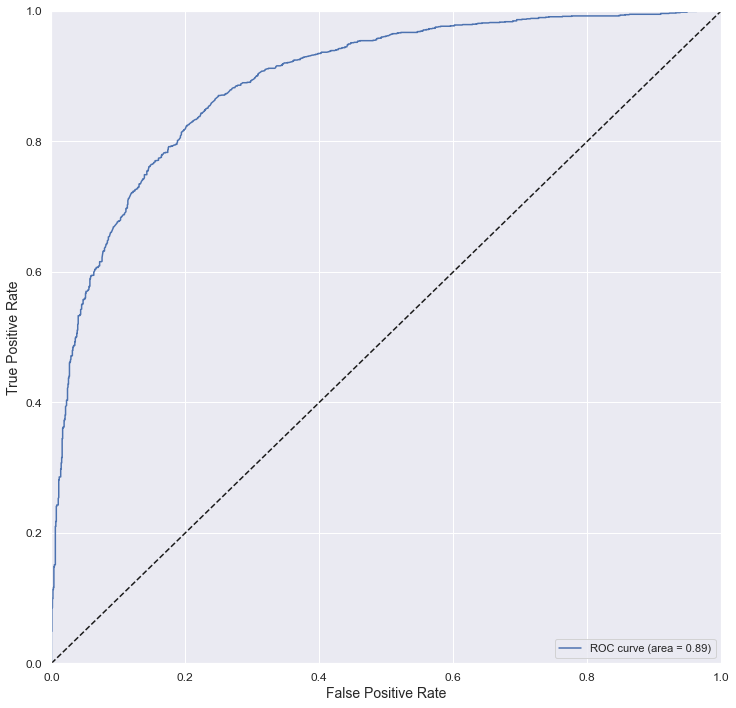

Accuracy_train:  0.8790		Accuracy_test:   0.8087
Precision_test:  0.8277		Recall_test:     0.8110
ROC-AUC_test:    0.8927		F1_test:         0.8193		MCC_test: 0.6162


In [9]:
orig_plt_params = plt.rcParams
sns.set()
cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
        mldatasets.evaluate_class_mdl(fitted_cb_mdl, X_train,\
                                      X_test, y_train, y_test) 

#### Getting Acquainted to our “Instance of Interest”

In [10]:
idx1 = 5231
idx2 = 2726
idx3 = 10127
eval_idxs = X_test.index.isin([idx1, idx2, idx3])
X_test_evals = X_test[eval_idxs]
eval_compare_df = pd.concat([\
            pd.DataFrame({'y':y_test[eval_idxs]},\
                         index=[idx3, idx2, idx1]),\
            pd.DataFrame({'y_pred':y_test_cb_pred[eval_idxs]},\
                         index=[idx3, idx2, idx1]),\
            X_test_evals], axis=1).transpose()

eval_compare_df

,10127,2726,5231
y,0,0,1
y_pred,0,0,1
age,24,23,23
juv_fel_count,0,0,0
juv_misd_count,0,0,0
juv_other_count,0,0,0
priors_count,2,2,2
sex_Female,0,0,0
sex_Male,1,1,1
race_African-American,0,0,1


## Understanding Anchor Explanations

### Preparations for Anchor and Counterfactual Explanations with Alibi

In [11]:
class_names = ['Low Risk', 'Medium/High Risk']

In [12]:
X_test_eval = np.expand_dims(X_test.values[X_test.\
                                           index.get_loc(idx1)], axis=0)
print(X_test_eval)

[[23  0  0  0  2  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]]


In [13]:
cat_vars_ohe = {5: 2, 7: 6, 13: 8}
print(ohe_to_ord(X_test_eval, cat_vars_ohe)[0])

[[23  0  0  0  2  1  0  3]]


In [14]:
category_map = {
    5: ['Female', 'Male'],
    6: ['African-American', 'Asian', 'Caucasian',\
        'Hispanic', 'Native American', 'Other'],
    7: ['Felony 1st Degree', 'Felony 2nd Degree',\
        'Felony 3rd Degree', 'Felony 7th Degree',\
        'Misdemeanor 1st Degree', 'Misdemeanor 2nd Degree',\
        'Misdemeanor 3rd Degree', 'Other Charge Degree']
}
feature_names = ['age', 'juv_fel_count', 'juv_misd_count',\
                 'juv_other_count', 'priors_count', 
                 'sex', 'race', 'c_charge_degree']

In [15]:
category_map_ohe = {5: ['Not Female', 'Female'], 6: ['Not Male', 'Male'],\
        7:['Not African American', 'African American'],\
        8:['Not Asian', 'Asian'], 9:['Not Caucasian', 'Caucasian'],\
        10:['Not Hispanic', 'Hispanic'],\
        11:['Not Native American', 'Native American'],\
        12:['Not Other Race', 'Other Race'],\
        13:['Not Felony 1st Level', 'Felony 1st Level'],\
        14:['Not Felony 2nd Level', 'Felony 2nd Level'],\
        15:['Not Felony 3rd Level', 'Felony 3rd Level'],\
        16:['Not Felony 7th Level', 'Felony 7th Level'],\
        17:['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],\
        18:['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],\
        19:['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],\
        20:['Not Other Charge Degree', 'Other Charge Degree']}

### Local Interpretations for Anchor Explanations

In [16]:
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)
anchor_cb_explainer = AnchorTabular(predict_cb_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)
anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None},
  'version': '0.6.5'}
)

In [17]:
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[idx1].values)[0]])

Prediction: Medium/High Risk


In [18]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx1].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	race_Caucasian = Not Caucasian
Precision: 0.898
Coverage: 0.120


In [19]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx1].values, threshold=0.9,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	c_charge_degree_(M1) = Not Misdemeanor 1st Deg AND
	c_charge_degree_(F3) = Not Felony 3rd Level AND
	race_Hispanic = Not Hispanic
Precision: 0.915
Coverage: 0.027


In [20]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx3].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage) #REMOVE CELL

Anchor: priors_count <= 2.00 AND
	c_charge_degree_(M1) = Misdemeanor 1st Deg AND
	race_African-American = Not African American
Precision: 0.871
Coverage: 0.101


In [21]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx2].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	sex_Female = Not Female AND
	juv_other_count <= 0.00
Precision: 0.865
Coverage: 0.230


## Exploring Counterfactual Explanations

### Counterfactual Explanations Guided by Prototypes

In [22]:
feature_range = (X_train.values.min(axis=0).reshape(1,21).astype(np.float32),\
                 X_train.values.max(axis=0).reshape(1,21).astype(np.float32))
print(feature_range)

(array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[96., 20., 13., 11., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32))


In [23]:
np.random.seed(rand)
tf.random.set_seed(rand)
cf_cb_explainer = CounterFactualProto(predict_cb_fn,
                                    X_test_eval.shape,
                                    max_iterations=500,
                                    feature_range=feature_range, 
                                    beta=.01, theta=5,\
                                    c_init = 1., c_steps = 2,
                                    use_kdtree=True
                                )
cf_cb_explainer.fit(X_test.values, d_type='abdm-mvdm')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


The class name `CounterFactualProto` is deprecated, please use `CounterfactualProto`.
No encoder specified. Using k-d trees to represent class prototypes.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.01,
              'feature_range': (array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[96., 20., 13., 11., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)),
              'gamma': 0.0,
              'theta': 5,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 500,
              'c_init': 1.0,
              'c_steps': 2,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'shape': (1, 21),
              'is_mo

In [24]:
%%time
cf_cb_explanation = cf_cb_explainer.explain(X_test_eval)
mldatasets.describe_cf_instance(X_test_eval, cf_cb_explanation, class_names,\
                  cat_vars_ohe, category_map, feature_names)

Instance Outcomes and Probabilities
------------------------------------------------
       original:  Medium/High Risk
                  [0.24722641 0.75277359]
 counterfactual:  Low Risk
                  [0.92013317 0.07986683]

Categorical Feature Counterfactual Perturbations
------------------------------------------------
	           race:  African-American  -->  Hispanic

Numerical Feature Counterfactual Perturbations
------------------------------------------------
CPU times: user 6.58 s, sys: 1.78 s, total: 8.36 s
Wall time: 5.18 s


### Counterfactual Instances and much more with the What-If-Tool (WIT)

#### Configuring WIT

In [26]:
shap_cb_explainer = shap.TreeExplainer(fitted_cb_mdl)

In [27]:
test_df = recidivism_df.loc[y_test.index]
test_np = test_df.values
cols_l = test_df.columns
delcol_idx = [cols_l.get_loc("is_recid"),\
              cols_l.get_loc("compas_score")]

In [28]:
def custom_predict_with_shap(examples_np):
    #For shap values we only need same features
    #that were used for training
    inputs_np = np.delete(np.array(examples_np),\
                          delcol_idx, axis=1)

    #Get the model's class predictions
    preds = predict_cb_fn(inputs_np)

    #With test data generate SHAP values which converted
    #to a list of dictionaries format
    keepcols_l = [c for i, c in enumerate(cols_l)\
                  if i not in delcol_idx]
    shap_output = shap_cb_explainer.shap_values(inputs_np)
    attributions = []
    for shap in shap_output:
        attrs = {}
        for i, col in enumerate(keepcols_l):
            attrs[col] = shap[i]
        attributions.append(attrs)
        
    #Prediction function must output 
    #predictions/attributions in dictionary
    output = {'predictions': preds,\
              'attributions': attributions}
    return output

#### Displaying WIT

In [29]:
print(y_test.index.get_loc(5231))

2910


In [30]:
wit_config_builder = WitConfigBuilder(\
                    test_np.tolist(), feature_names=cols_l.tolist()
                ).set_custom_predict_fn(custom_predict_with_shap).\
                set_target_feature("is_recid").set_label_vocab(class_names)
WitWidget(wit_config_builder, height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['Low Risk', 'Medium/High Risk'], 'feature_na…